In [89]:
import os
import time
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


In [2]:
#fake_2 = fake.detach()

#Usar o fixed_noise para salvar as imagens!

### System properties and libs currently in use
- We have developed using python 3.5.x, pytorch 0.2.1
- No significant attention was given to backwards compatibility

In [3]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())

__Python VERSION: 3.5.3 |Anaconda 4.4.0 (64-bit)| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
__pyTorch VERSION: 0.2.0_4
__CUDA VERSION
__CUDNN VERSION: 6021
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0


### Utilities
- Saving images and models

In [70]:
def save_images(netG, fixed_noise, outputDir,epoch):
    '''
    Generates a batch of images from the given 'noise'.
    Saves 64 of the generated samples to 'outputDir' system path.
    Inputs are the network (netG), a 'noise' input, system path to which images will be saved (outputDir) and current 'epoch'.
    '''
    assert isinstance(fixed_noise,torch.autograd.variable.Variable)
    netG.eval()
    fake = netG(noise)
    netG.train()
    vutils.save_image(fake.data[0:64,:,:,:],'%s/fake_samples_epoch_%03d.png' % (outputDir, epoch), nrow=8)

def save_models(netG, netD, outputDir, epoch):
    '''
    Saves model state dictionary for generator and discriminator networks.
    Inputs are the networks (netG, netD), the system path in which to save(outputDir) and the current 'epoch'.
    '''
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outputDir, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outputDir, epoch))

In [71]:
def plot_samples(samples):
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples[:25]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig

In [ ]:
def save_images2(g_net,fixed_noise,epoch):
    g_net.eval()
    fake_data = g_net(fixed_noise)
    g_net.train()
    fig = plot_samples(fake_data.data.cpu().numpy())
    plt.savefig(outputDir + '/dcgan_img_{:04d}.png'.format(epoch, bbox_inches='tight'))
    plt.close(fig)


In [ ]:
cudnn.benchmark = True

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("You are using CUDA. If it is not what you want, manually set this as False!")
print(use_gpu)

### Output Directory
This is where images will be saved to.

If directory does not exist, it is created.

In [ ]:
outputDir = 'outputdir_train_classifier_teste2'

try:
    os.makedirs(outputDir)
except OSError as err:
    print("OS error: {0}".format(err))

### Dataset definition and hyperparameter setting
- Changing dataset name alters network architecture parameters
- Currently supporting few datasets
- Hyperparameters defined according to Radford et al. (2015)

Valores típicos são

nc = 3,

ngpu = 1,

nz = 100,

ngf = 64,

ndf = 64,

n_extra_d = 0,

n_extra_g = 1,

imageSize = 64

In [ ]:
batch_size = 64

chosen_dataset = 'MNIST'

datasets = {
    'MNIST': torchvision.datasets.MNIST,
    'CIFAR10': torchvision.datasets.CIFAR10,
    'ANIME': '/home/gabriel/Redes Neurais/Projeto_Final_GANS/Tutorial_2/dataset/min_anime-faces',
}

dataset = datasets[chosen_dataset]

In [ ]:
possible_parameters = {
    'MNIST': {
        'ndf': 64,
        'ngf': 64,
        'nz': 100,
        'nc': 1,
        'imageSize': 28,
        'n_classes' : 10,
        'ngpu': 1,
    },
    'CIFAR10': {
        'ndf': 64,
        'ngf': 64,
        'nz': 100,
        'nc': 3,
        'imageSize' : 64,
        'n_classes' : 10,
        'ngpu' : 1,
    },
    'ANIME': {
        'nc' : 3,
        'ngpu' : 1,
        'nz' : 100,
        'ngf' : 64,
        'ndf' : 64,
        'imageSize' : 64,
        'n_classes' : 1
    }
}

In [ ]:
ngf = possible_parameters[chosen_dataset]['ngf']
ndf = possible_parameters[chosen_dataset]['ndf']
nz = possible_parameters[chosen_dataset]['nz']
nc = possible_parameters[chosen_dataset]['nc']
imageSize = possible_parameters[chosen_dataset]['imageSize']
n_classes = possible_parameters[chosen_dataset]['n_classes']
ngpu = possible_parameters[chosen_dataset]['ngpu']

## Creating the Dataset!

In [ ]:
if dataset == 'ANIME':
    dataset = torchvision.datasets.ImageFolder(
        root='/home/gabriel/Redes Neurais/Projeto_Final_GANS/Tutorial_2/dataset/min_anime-faces',
        transform=transforms.Compose([
                transforms.Scale((imageSize, imageSize)),
                transforms.ToTensor(),
            ])
    )
else:
    transform = transforms.Compose([
                    transforms.Scale((imageSize, imageSize)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)), # bring images to (-1,1)
                ]) 
    dataset_done = dataset('./datasets', train=True, download=True, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset_done, batch_size=batch_size, shuffle=True, num_workers=4)
print('Dataloader length:', len(dataloader))
print("Dataset:", dataloader.dataset)


## Definição dos modelos
- Model is a DCGAN
- Images are sized (nc, 64, 64)

In [ ]:
class _netD_DCGAN(nn.Module):
    def __init__(self, ngpu, nz, nc, ndf, n_classes):
        super(_netD_DCGAN, self).__init__()
        self.ngpu = ngpu
        self.conv1 = nn.Conv2d(in_channels = nc, out_channels = ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels = ndf, out_channels = ndf*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(in_channels = ndf*2, out_channels = ndf*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(in_channels = ndf*4, out_channels = ndf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch4 = nn.BatchNorm2d(ndf * 8)
        
        #self.final_conv = nn.Conv2d(in_channels=ndf*8, out_channels=n_classes+1,kernel_size=4,stride=1,padding=0,bias=False)
        self.final_conv = nn.Conv2d(in_channels=ndf*8, out_channels=1,kernel_size=4,stride=1,padding=0,bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, inplace=True)
        x = F.leaky_relu(self.batch2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch4(self.conv4(x)), 0.2, inplace=True)
        x = self.final_conv(x)
        x = F.sigmoid(x)
        
        #x = x.view(-1, 1).squeeze(1)

        return(x)

In [ ]:
class _netG_DCGAN(nn.Module):
    def __init__(self, ngpu, nz, nc , ngf):
        super(_netG_DCGAN, self).__init__()
        self.ngpu = ngpu
        self.convt1 = nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.batch1 = nn.BatchNorm2d(ngf*8)
        self.convt2 = nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch2 = nn.BatchNorm2d(ngf*4)
        self.convt3 = nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch3 = nn.BatchNorm2d(ngf*2)
        self.convt4 = nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch4 = nn.BatchNorm2d(ngf)
        
        self.final_convt = nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.batch1(self.convt1(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch2(self.convt2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch3(self.convt3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.batch4(self.convt4(x)), 0.2, inplace=True)
        
        x = self.final_convt(x)
        x = F.tanh(x)
        return (x)

In [ ]:
class _netG_DCGAN_MNIST(nn.Module):
    def __init__(self, nz, nc, ngf=64):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
class _netD_DCGAN_MNIST(nn.Module):
    def __init__(self, nc, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


In [ ]:
#netG = _netG_DCGAN(ngpu, nz, nc, ngf)
netG = _netG_DCGAN_MNIST(nz=nz, nc=nc, ngf=64)
#netD = _netD_DCGAN(ngpu, nz, nc, ndf, n_classes)
netD = _netD_DCGAN_MNIST(nc=nc, ndf=64)


## Inicializador de pesos

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
netG.apply(weights_init)
netD.apply(weights_init)
print(netG, '\n', netD)

## Losses
- Binary Cross-Entropy is used to differentiate real and fake images
- Class loss should be Cross-Entropy

In [ ]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

## Sizes of the tensors

In [ ]:

label = torch.FloatTensor(batch_size)
print(label.size())

In [ ]:
# make our input tensors
d_input = torch.FloatTensor(batch_size, 3, imageSize, imageSize)
print('Input images size:', d_input.size())
#nz its the latent dimension
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
print('Code size:', noise.size())

In [ ]:
#label = torch.LongTensor(batch_size,n_classes)
label = torch.LongTensor(batch_size)
print('Label size:', label.size())
#fake_label = 10
fake_label = 0
real_label = 1

## Broadcast to GPU

In [ ]:
if use_gpu:
    netD.cuda()
    netG.cuda()
    criterion = criterion.cuda()
    d_input,label = d_input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

## Turning tensors into Variables

In [ ]:

d_input = Variable(d_input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)

## Optimizer Parameters
- Following the lead of Radford et al., 2015:

    <b>
    1. beta1 = 0.5
    2. beta2 = 0.999
    3. lr = 0.0002
    </b>

In [ ]:
beta1, beta2 = 0.5, 0.999
lr = 2.0e-4
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, beta2))
#optimizerD = optim.Adam(netD_parallel.parameters(), lr = lr, betas = (beta1, beta2))

optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, beta2))
#optimizerG = optim.Adam(netG_parallel.parameters(), lr = lr, betas = (beta1, beta2))

In [ ]:
test_input_G = torch.randn(64, 100, 1, 1)
test_input_G = Variable(test_input_G)
test_output_G = netG(test_input_G.cuda())
print('Generator output size:', test_output_G.size())
then = time.time()
test_output_D = netD(test_output_G)
now = time.time()
print('Discriminator output size:', test_output_D.size())
print("Time taken: {0:.5f} s".format(now-then))


## Treinamento 

In [ ]:
#print(np.random.random_sample())
#real_labelSmooth = 0.2
#print(real_labelSmooth)
#target = torch.from_numpy(np.random.randint(0, n_classes, batch_size)).type(torch.LongTensor).cuda()
#print(target.size())


In [ ]:
print(d_input.size())
print(label.size())

In [ ]:
print("done")

In [115]:
for k,i in enumerate(dataloader):
    pass
print(k)
print(int(len(dataloader.dataset)/dataloader.batch_size))


937
937


<function default_collate at 0x7f762bc4c950>


SyntaxError: invalid character in identifier (<ipython-input-122-701f821b0026>, line 103)

In [140]:

def train_gan(num_epochs, dataloader, netD, netG, outputDir, label, noise,
              real_labelSmooth=0, epoch_interval=100, D_steps=1, G_steps=1):
    
    # This validation is subjective. WGAN-GP uses 100 steps on the critic (netD).
    assert D_steps < 5, "Keep it low, D_steps is too high."
    assert G_steps < 3, "Keep it low, G_steps is too high."
    #assert batch_size % D_steps == 0, "Use batch_size multiple of D_steps."
    real_label = 1
    size = int(len(dataloader.dataset)/dataloader.batch_size)
    print('Lets train!')
    loss_D = []
    loss_G = []
    for epoch in range(num_epochs):
        start_iter = time.time()  
        D_x = 0
        D_G_z1 = 0
        D_G_z2 = 0
        errD_acum = 0
        errG_acum = 0

        for batch, data in enumerate(dataloader, 0):
            if (epoch == 0 and batch == 0):
                fig = plot_samples(data[0][0:data[0].size(0),:,:,:].cpu().numpy())
                plt.savefig(outputDir + '/real_samples.png.png'.format(epoch, bbox_inches='tight'))
                plt.close(fig)
                #vutils.save_image(data[0][0:data[0].size(0),:,:,:], '%s/real_samples.png' % outputDir, nrow=8)
            for step in range(D_steps):
                #############################################################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                # 1A - Train the detective network in the Real Dataset
                #############################################################
                netD.zero_grad()
                start = step*(int(data[0].size()[0]/D_steps))
                end = (step+1)*int(data[0].size()[0]/D_steps)
                #real_cpu = data[0][start:end]
                #if use_gpu:
                    #real_cpu = real_cpu.cuda()
                #d_input.resize_as_(data[0][start:end]).copy_(data[0][start:end])
                d_input.data.resize_(data[0][start:end].size()).copy_(data[0][start:end])
                
                batch_size = data[0][start:end].size(0)
                #batch_size = real_cpu.size(0)
                
                #label.data.resize_(batch_size).fill_(real_label - d_labelSmooth) # use smooth label for discriminator
                label.data.resize_(batch_size).fill_(real_label)

                
                #  if np.random.random_sample() > real_labelSmooth:        
                #target = data[1][start:end].long().cuda()
                #else:
                #     target = torch.from_numpy(np.random.randint(0, n_classes, batch_size)).type(torch.LongTensor).cuda()
                
                #d_input, label = Variable(real_cpu), Variable(target)
                
                output = netD(d_input)
                #print('output size',output.size())
                errD_real = criterion(output.squeeze(),label.float())
                #errD_real = criterion(output,label)
                
                errD_real.backward()
                
                D_x += output.data.mean()
                
                #######################################################
                # 1B - Train the detective network in the False Dataset
                #######################################################
                
                noise = Variable(torch.FloatTensor(batch_size, nz, 1, 1).normal_(0,1).cuda())
                fake = netG(noise)
                
                #print('fake',fake.size())
                #label = Variable(torch.ones(batch_size).long().fill_(fake_label).cuda())
                label.data.resize_(batch_size).fill_(fake_label)
                
                output = netD(fake.detach()) # ".detach()" to avoid backprop through G
                
                errD_fake = criterion(output.squeeze(), label.float())
                errD_fake.backward() # gradients for fake and real data will be accumulated
                
                D_G_z1 += output.data.mean()
                errD_acum += errD_real.data[0] + errD_fake.data[0]
                optimizerD.step() # .step() can be called once the gradients are computed

            for step in range(G_steps):
                ####################################################################################
                # (2) Update G network: maximize log(D(G(z)))
                # Train the faker with the output from the Detective (but don't train the Detective)
                ####################################################################################
                
                netG.zero_grad()
                #tudo 1
                #label = Variable(torch.from_numpy(np.random.randint(0, n_classes, batch_size)).type(torch.LongTensor).cuda())
                #label = Variable(torch.ones(batch_size).long().fill_(real_label).cuda())
                label.data.resize_(batch_size).fill_(real_label)
                
                output = netD(fake)
                errG = criterion(output.squeeze(), label.float())
                errG.backward()
                
                D_G_z2 += output.data.mean()
                errG_acum += errG.data[0]
                optimizerG.step()
                #del input, noise, label, output

        print('epoch = ',epoch)

        end_iter = time.time()        

        print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z1)): %.4f D(G(z2)) %.4f Time Elapsed %.2f s'
            % (epoch, num_epochs, (errD_acum/D_steps)/size, (errG_acum/G_steps)/size, D_x, D_G_z1, D_G_z2, end_iter-start_iter))

        loss_D.append((errD_acum/D_steps)/size)
        loss_G.append((errG_acum/G_steps)/size)
        #Save a grid with the pictures from the dataset, up until 64
        #save_images(netG = netG, fixed_noise=  fixed_noise, outputDir = outputDir, epoch = epoch)
        print('printing')
        save_images2(netG,fixed_noise,epoch)

        if epoch % epoch_interval == 0:
            # do checkpointing
            save_models(netG = netG, netD = netD, outputDir = outputDir, epoch = epoch)
    return(loss_D,loss_G)

In [141]:
num_epochs = 25
real_labelSmooth = 0.2

loss_D,loss_G = train_gan(num_epochs, dataloader, netD,netG, outputDir,label,noise, real_labelSmooth)

Lets train!
epoch =  0
[0/25] Loss_D: 0.0786 Loss_G: 6.3013 D(x): 908.6744 D(G(z1)): 29.4261 D(G(z2)) 11.2521 Time Elapsed 15.17 s
printing
epoch =  1
[1/25] Loss_D: 0.1836 Loss_G: 6.1096 D(x): 890.3100 D(G(z1)): 47.9416 D(G(z2)) 21.4940 Time Elapsed 13.70 s
printing
epoch =  2
[2/25] Loss_D: 0.1807 Loss_G: 6.1357 D(x): 887.1896 D(G(z1)): 50.7660 D(G(z2)) 23.8452 Time Elapsed 14.34 s
printing
epoch =  3
[3/25] Loss_D: 0.0806 Loss_G: 6.2334 D(x): 908.0666 D(G(z1)): 29.9582 D(G(z2)) 11.6402 Time Elapsed 14.28 s
printing
epoch =  4
[4/25] Loss_D: 0.1646 Loss_G: 6.2290 D(x): 892.7304 D(G(z1)): 45.3577 D(G(z2)) 19.1500 Time Elapsed 14.30 s
printing
epoch =  5
[5/25] Loss_D: 0.1324 Loss_G: 6.1972 D(x): 896.5648 D(G(z1)): 41.2363 D(G(z2)) 18.1537 Time Elapsed 14.08 s
printing
epoch =  6
[6/25] Loss_D: 0.1403 Loss_G: 6.1741 D(x): 893.5442 D(G(z1)): 44.6985 D(G(z2)) 18.0313 Time Elapsed 14.20 s
printing
epoch =  7
[7/25] Loss_D: 0.1357 Loss_G: 6.1283 D(x): 895.8231 D(G(z1)): 42.2549 D(G(z2)) 18

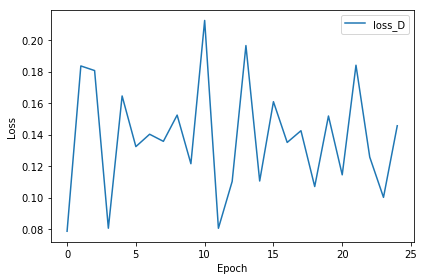

In [142]:
def plot_graph(loss,label):
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(0,num_epochs),loss, label = label)
    #plt.grid(True)
    plt.tight_layout()
    plt.legend()
plot_graph(loss_D,'loss_D')

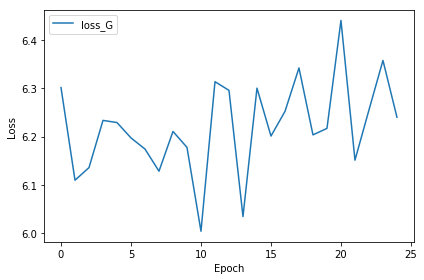

In [143]:
plot_graph(loss_G,'loss_G')

In [144]:
def plot_histories():
    x = range(len(d)

SyntaxError: unexpected EOF while parsing (<ipython-input-144-50248e7d1ceb>, line 2)

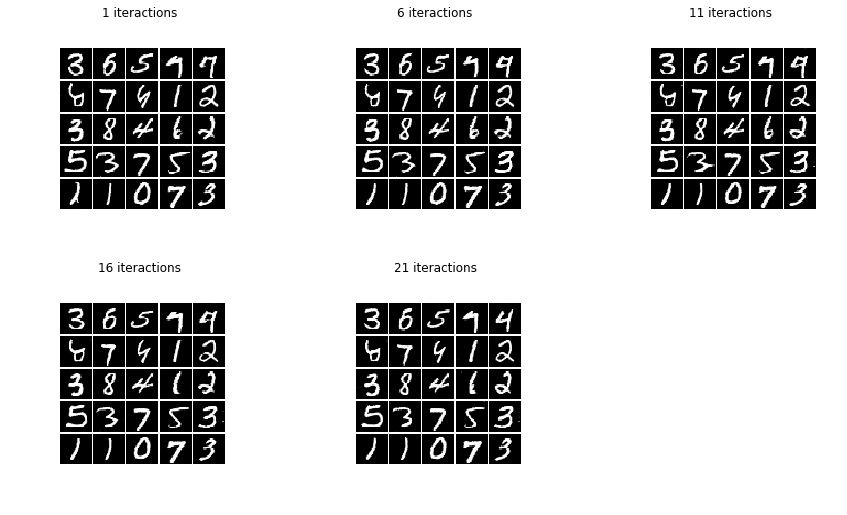

In [145]:
def final_plot(num_epochs,save_interval,outputDir):

    fig = plt.figure(figsize=(15, 18))

    for i, fn in enumerate(range(0, num_epochs, save_interval)):
        fig.add_subplot(4, 3, i+1)
        image_fn = outputDir + '/dcgan_img_{:04d}.png'.format(fn)

        img = plt.imread(image_fn)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title('{} iteractions'.format(fn+1))
        
final_plot(num_epochs=num_epochs, save_interval=5,outputDir = outputDir)